In [1]:
import matplotlib.pyplot as plt
import numpy as np

from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_power_spectra
from neurodsp.sim import sim_bursty_oscillation

from timescales.sim import sim_spikes_synaptic
from timescales.est.acf import compute_acf, fit_acf, fit_acf_cos, sim_acf_cos
from timescales.est.psd import fit_psd

from fooof import FOOOF

In [2]:
np.random.seed(0)

n_seconds = 100
fs = 1000
tau = .01
mu = 20
    
niters = 100
nlags = 1000
f_range = (1, 100)

powers = np.zeros((niters, f_range[-1]))
corrs  = np.zeros((niters, nlags))
probs  = np.zeros((niters, int(n_seconds * fs)))
fms = []
kf = []
kt = []
acf_taus = []

for i in range(niters):
    
    # Simulate
    _probs, _ = sim_spikes_synaptic(n_seconds, fs, tau, mu=mu, n_neurons=1)
    probs[i] = _probs
    
    # Fit Spectra
    freqs, _powers = compute_spectrum(_probs, fs, f_range=f_range)
    powers[i] = _powers
    
    fooof_init = {'peak_threshold': 3, 'min_peak_height': 1}
    fm, knee_freq, knee_tau = fit_psd(_probs, fs, f_range, fooof_init=fooof_init)
    fms.append(fm)
    kf.append(knee_freq)
    kt.append(knee_tau)
    
    # Fit acf
    _corrs = compute_acf(_probs, nlags)
    _params_acf = fit_acf(_corrs)
    corrs[i] = _corrs
    
    acf_taus.append(_params_acf[1]/fs)


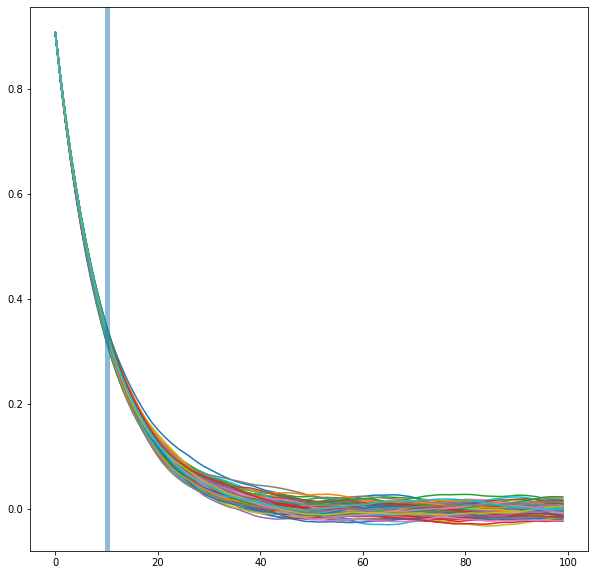

In [3]:
plt.figure(figsize=(10, 10))
for c in corrs:
    plt.plot(c[:100])
plt.axvline(10, lw=5, alpha=.5);

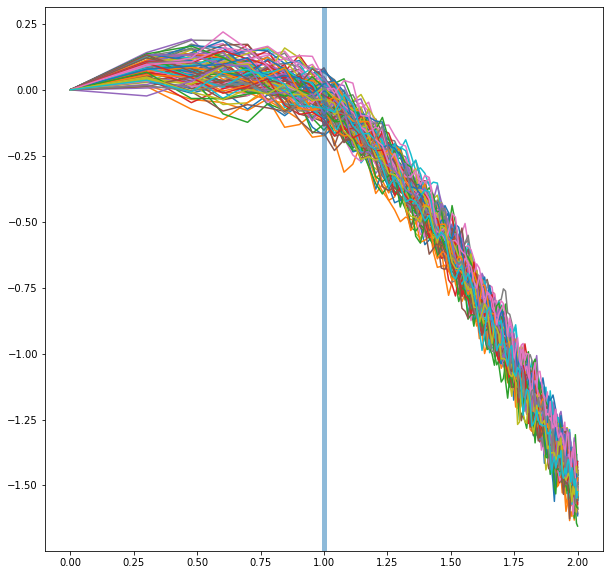

In [4]:
plt.figure(figsize=(10, 10))
for p in powers:
    plt.plot(np.log10(freqs), np.log10(p / p[0]))
    
plt.axvline(np.log10(10), lw=5, alpha=.5);

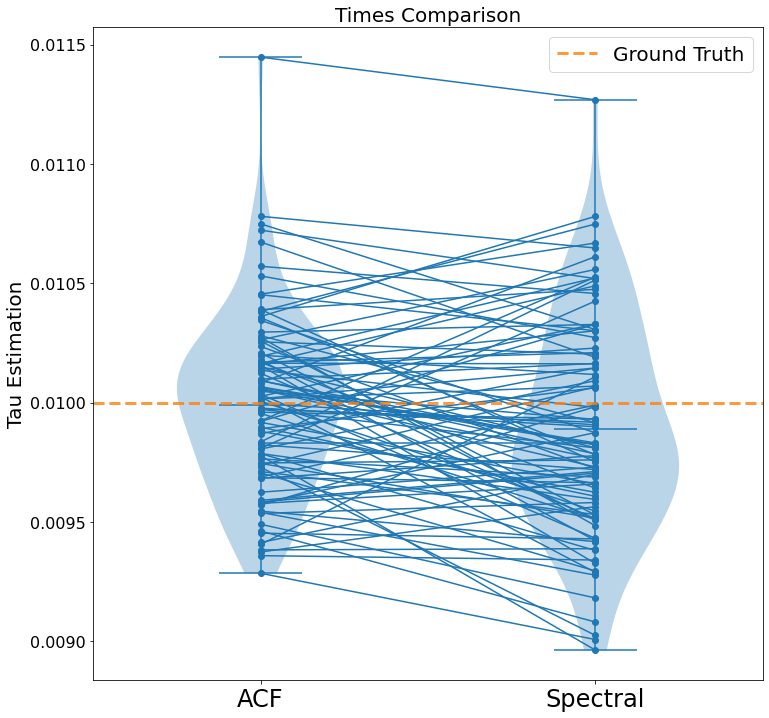

In [5]:
plt.figure(figsize=(12, 12))

acf_tau_no_cos = acf_taus.copy()
kt_no_cos = kt.copy()

for a, b in zip(acf_taus, kt):
    plt.plot([1, 2], [a, b], 'o-', color='C0')
    
plt.violinplot([acf_taus, kt], showmeans=True)
plt.axhline(.01, color='C1', ls='dashed', alpha=.8, lw=3, label='Ground Truth')


plt.xticks([1, 2], labels=['ACF', 'Spectral'], fontsize=24)
plt.yticks(fontsize=16)
plt.xlim(0.5, 2.5)
plt.ylabel('Tau Estimation', fontsize=20)
plt.title('Times Comparison', fontsize=20)
plt.legend(fontsize=20);

#plt.savefig('method_comparison.png')

### Oscillatory Compoennts

Here, we visualize the ACF with cosine fitting approach, a method to account for oscillations.

In [6]:
# Settings
n_seconds = 100
fs = 1000
tau = .1
mu = 20
freq = 10
nlags = 1000
niters = 100
f_range = (1, 100)
variances = (1, .25)

# Simulate
exp, _ = sim_spikes_synaptic(n_seconds, fs, tau, mu=mu)
cos = sim_bursty_oscillation(n_seconds, fs, freq, phase='max')

probs = (exp * variances[0]) + (cos * variances[1])
probs /= np.max(probs)


# Fit
corrs = compute_acf(probs, nlags)
params = fit_acf_cos(corrs, fs, progress='tqdm.notebook')

# Separate components
_probs = (exp * variances[0])
exp_sim = compute_acf(_probs, nlags)

_probs = (cos * variances[1])
cos_sim = compute_acf(_probs, nlags)

xs = np.arange(len(corrs))
ys_hat = sim_acf_cos(xs, fs, *params)
e, c = sim_acf_cos(xs, fs, *params, return_sum=False)

Sim Tau:  0.1
Est Tau:  0.10393850494982342


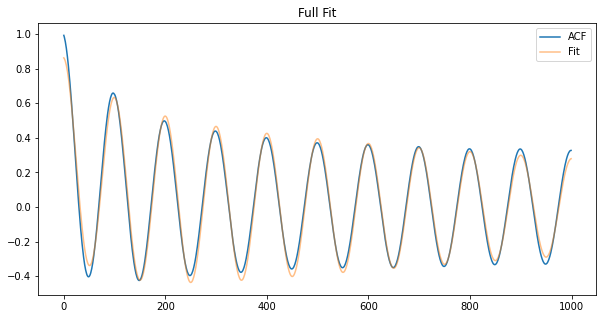

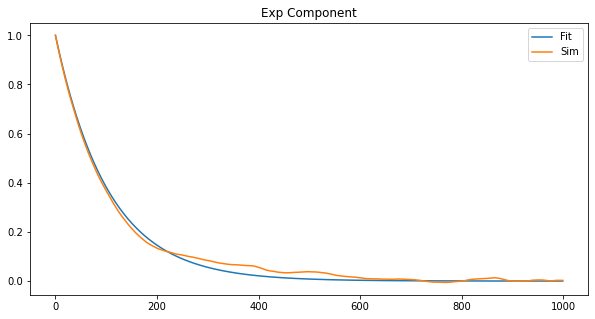

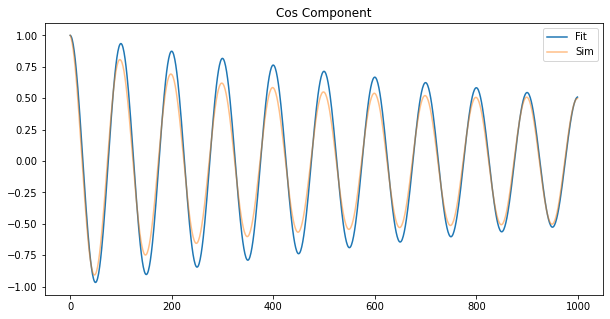

In [7]:
# Results
print('Sim Tau: ', tau)
print('Est Tau: ', params[1])

plt.figure(0, figsize=(10, 5))
plt.title('Full Fit')
plt.plot(corrs, label='ACF')
plt.plot(ys_hat, label='Fit', alpha=.5)
plt.legend()

plt.figure(1, figsize=(10, 5))
plt.title('Exp Component')
plt.plot(e / np.max(e), label='Fit')
plt.plot(exp_sim / np.max(exp_sim), label='Sim')
plt.legend();

plt.figure(2, figsize=(10, 5))
plt.title('Cos Component')
plt.plot(c / np.max(c), label='Fit')
plt.plot(cos_sim / np.max(cos_sim), label='Sim', alpha=.5)
plt.legend();

In [8]:
def sim_iters(n_seconds, fs, tau, mu, nlags, f_range, niters, freq=None, variances=None):
    
    powers = np.zeros((niters, f_range[-1]))
    corrs  = np.zeros((niters, nlags))
    probs  = np.zeros((niters, int(n_seconds * fs)))

    fms = []
    kf = []
    kt = []
    acf_taus = []

    for i in range(niters):

        # Simulate
        exp, _ = sim_spikes_synaptic(n_seconds, fs, tau, mu=mu, n_neurons=1)
        
        if freq is not None and variances is not None:
            cos = sim_bursty_oscillation(n_seconds, fs, freq, phase='max')
            _probs = (exp * variances[0]) + (cos * variances[1])
            _probs /= np.max(_probs)
        else:
            _probs = exp
            
        probs[i] = _probs

        # Fit Spectra
        freqs, _powers = compute_spectrum(_probs, fs, f_range=f_range)
        powers[i] = _powers

        if freq is not None and variances is not None:
            fooof_init = {'max_n_peaks': 1, 'peak_threshold': 3}
        else:
            fooof_init = {'max_n_peaks': 0}
            
        fm, knee_freq, knee_tau = fit_psd(_probs, fs, f_range)
        fms.append(fm)
        kf.append(knee_freq)
        kt.append(knee_tau)

        # Fit acf
        _corrs = compute_acf(_probs, nlags)
        
        if freq is not None and variances is not None:
            _params_acf = fit_acf_cos(_corrs, fs)
            acf_taus.append(_params_acf[1])
        else:
            _params_acf = fit_acf(_corrs)
            acf_taus.append(_params_acf[1]/fs)
            
        corrs[i] = _corrs

        
    return probs, fms, kf, kt, corrs, acf_taus


def plot_sim_results(taus_acf, taus_spec, tau_sim, title, ax):


    for a, b in zip(taus_acf, taus_spec):
        ax.plot([1, 2], [a, b], 'o-', color='C0')

    ax.violinplot([taus_acf, taus_spec], showmeans=True)
    ax.axhline(tau_sim, color='C1', ls='dashed', alpha=.8, lw=3, label='Ground Truth')


    ax.set_xticks([1, 2])
    ax.set_xticklabels(labels=['ACF', 'Spectral'], size=24)
    ax.tick_params(labelsize=18)
    ax.set_xlim(0.5, 2.5)
    ax.set_ylabel('Tau', size=20)
    ax.set_title(title, size=20)
    ax.legend(fontsize=14)

# Results

The spectral method performs better for small taus. As tau increases, the knee moves to lower frequencies, where the frequency resolution is smaller in log-log, and thus produces inaccurate estimates.

In general, small taus are better estimated by the spectral method, and large taus are better estimated by the ACF method.

In [9]:
n_seconds = 100
fs = 1000

mu = 20
freq = 10
nlags = 1000
niters = 50
f_range = (1, 100)
variances = (1, .25)

# Lower tau
tau_lo = .01
results = sim_iters(n_seconds, fs, tau_lo, mu, nlags, f_range, niters)
_, _, _, taus_spec_lo, _, taus_acf_lo = results

# Lower tau + Cos
results = sim_iters(n_seconds, fs, tau_lo, mu, nlags, f_range, niters, freq, variances)
_, _, _, taus_spec_lo_cos, _, taus_acf_lo_cos = results

# Higher tau
tau_hi = .1
results = sim_iters(n_seconds, fs, tau_hi, mu, nlags, f_range, niters)
_, _, _, taus_spec_hi, _, taus_acf_hi = results

# Higher tau + Cos
tau_hi = .1
results = sim_iters(n_seconds, fs, tau_hi, mu, nlags, f_range, niters, freq, variances)
_, _, _, taus_spec_hi_cos, _, taus_acf_hi_cos = results


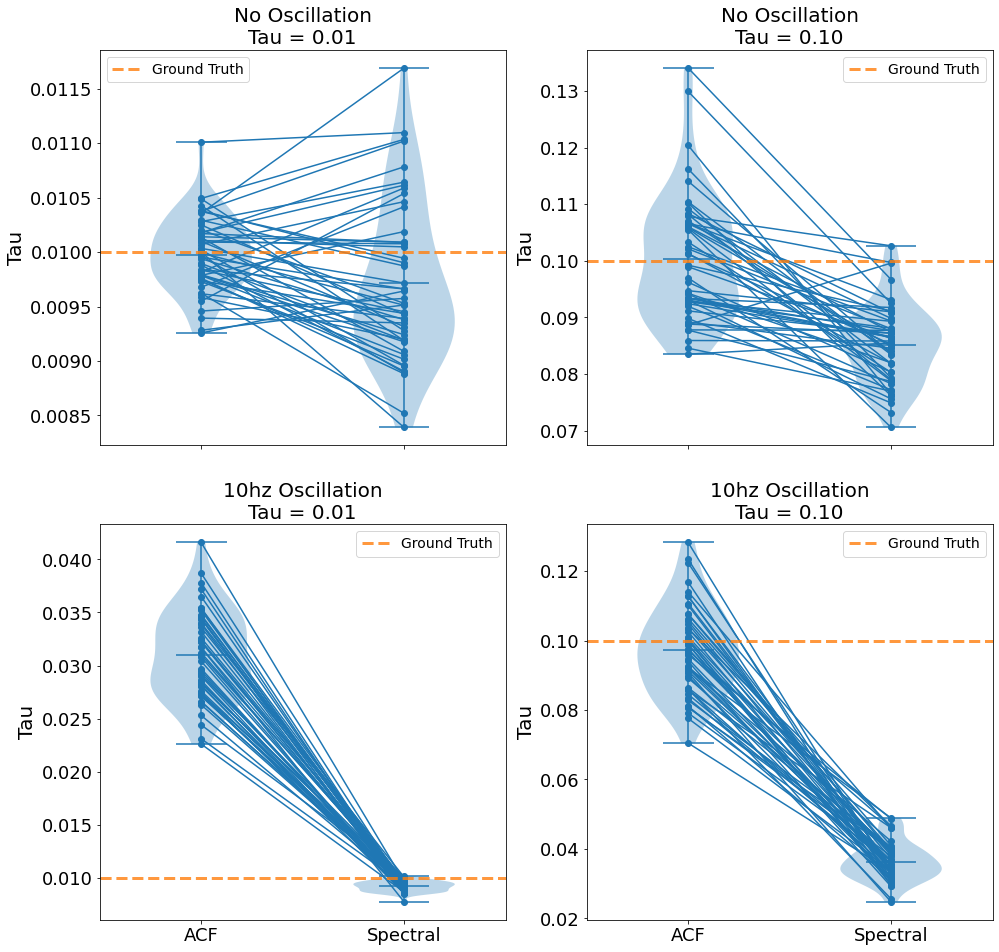

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 16), sharex=True)

plot_sim_results(taus_acf_lo, taus_spec_lo, tau_lo, 'No Oscillation\nTau = 0.01', axes[0][0])
plot_sim_results(taus_acf_hi, taus_spec_hi, tau_hi, 'No Oscillation\nTau = 0.10', axes[0][1])

plot_sim_results(taus_acf_lo_cos, taus_spec_lo_cos, tau_lo, '10hz Oscillation\nTau = 0.01', axes[1][0])
plot_sim_results(taus_acf_hi_cos, taus_spec_hi_cos, tau_hi, '10hz Oscillation\nTau = 0.10', axes[1][1])

#plt.savefig('method_comparison.png')

### Further Comparison

The plots below show why longer taus are better estimated using the ACF method over the spectral method.

In [12]:
np.random.seed(0)

n_seconds = 100
fs = 1000
tau = .01
mu = 20
nlags = 500 
niters = 100
f_range = (0, 250)

taus = np.linspace(.001, .1, 10)

corrs = np.zeros((len(taus), nlags))
params = np.zeros((len(taus), 3))
powers = np.zeros((len(taus), f_range[1]+1))
probs = np.zeros((len(taus), int(fs * n_seconds)))

for ind, t in enumerate(taus):
    
    _probs, _ = sim_spikes_synaptic(n_seconds, fs, t, mu=mu, n_neurons=1)
    
    freqs, _power = compute_spectrum(_probs, fs, f_range=f_range)
    _corrs = compute_acf(_probs, nlags)
    _params = fit_acf(_corrs)
    
    probs[ind] = _probs
    powers[ind] = _power / _power.max()
    corrs[ind] = _corrs
    params[ind] = _params

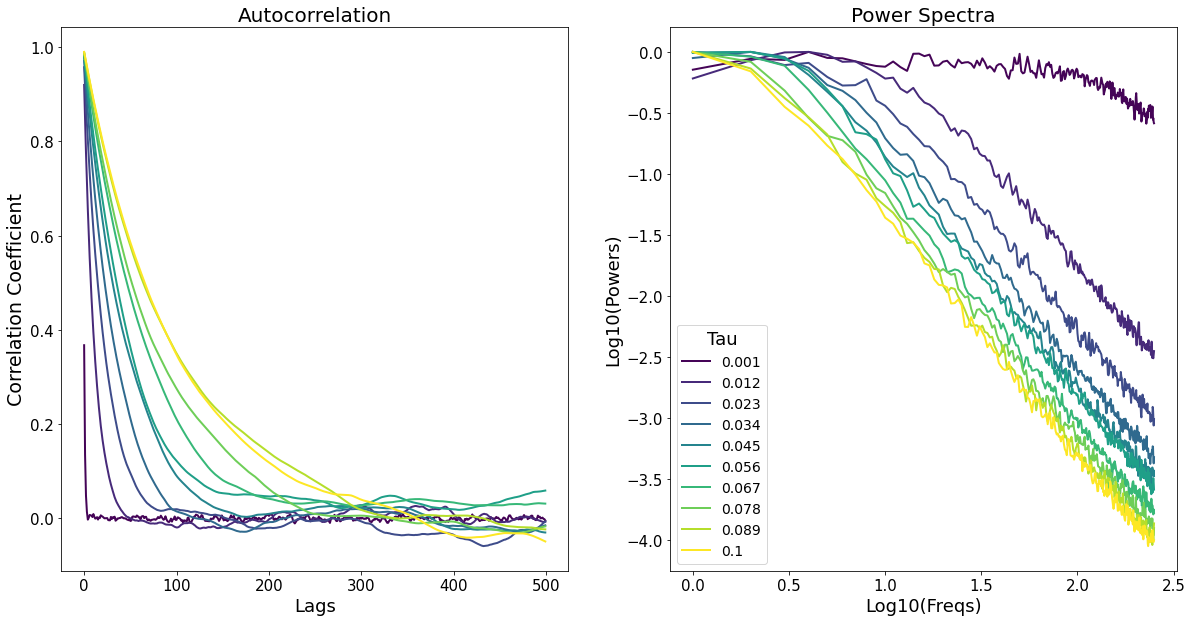

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))

cmap = plt.get_cmap('viridis')
colors = cmap(taus / taus.max())

for p, t, c in zip(powers, taus, colors):
    axes[1].plot(np.log10(freqs[1:]), np.log10(p[1:]), color=c, label=t.round(3), lw=2)

for corr, t, color in zip(corrs, taus, colors):
    axes[0].plot(corr, color=color, label=t.round(3), lw=2)

axes[0].set_xlabel('Lags', size=18)
axes[0].set_ylabel('Correlation Coefficient', size=19)
axes[0].tick_params(labelsize=15)
axes[0].set_title('Autocorrelation', size=20)

axes[1].set_xlabel('Log10(Freqs)', size=18)
axes[1].set_ylabel('Log10(Powers)', size=18)
axes[1].tick_params(labelsize=15)
axes[1].set_title('Power Spectra', size=20)



axes[1].legend(title='Tau', title_fontsize=18, prop={'size': 14});

#plt.savefig('acf_vs_spectral.png')